# ChatGPT Review Analysis Project

### Problem Statement
People have shared a wide range of feedback about ChatGPT through ratings and written reviews.  
This project analyzes those reviews to understand:
- Sentiment (positive/neutral/negative)
- Key issues driving negative feedback
- Common positive features
- Sentiment trends over time

### Dataset Fields
- Review ID
- Review
- Ratings (0–5)
- Review Date


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

!pip -q install textblob wordcloud
from textblob import TextBlob
from wordcloud import WordCloud

## 1. Data Loading
The dataset is uploaded and loaded into a pandas DataFrame.



In [10]:
from google.colab import files
uploaded = files.upload()

Saving chatgpt_reviews.csv to chatgpt_reviews (1).csv


In [37]:


file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

df.head()


,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


## 2. Data Inspection
We inspect dataset size, columns, and data types.


In [38]:
df.shape, df.columns


((196727, 4),
 Index(['Review Id', 'Review', 'Ratings', 'Review Date'], dtype='object'))

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


## 3. Data Preparation / Cleaning
Steps performed:
- Standardize column names
- Handle missing values
- Convert ratings to numeric
- Convert review date to datetime


In [40]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.head()


,review_id,review,ratings,review_date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


In [41]:
df['review'] = df['review'].fillna("").astype(str)

df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')

df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce', dayfirst=True)

df.isnull().sum()


/tmp/ipython-input-1079997472.py:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce', dayfirst=True)


,0
review_id,0
review,0
ratings,0
review_date,0


In [42]:
df = df.dropna(subset=['ratings', 'review_date'])
df.shape


(196727, 4)

## 4. Sentiment Analysis
We compute:
- Polarity (-1 to +1)
- Subjectivity (0 to 1)

Then classify sentiment into:
- Positive
- Neutral
- Negative


In [43]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df[['polarity', 'subjectivity']] = df['review'].apply(lambda x: pd.Series(get_sentiment(x)))
df[['review','polarity','subjectivity']].head()


,review,polarity,subjectivity
0,good,0.7000,0.600000
1,good,0.7000,0.600000
2,nice app,0.6000,1.000000
3,"nice, ig",0.6000,1.000000
4,"this is a great app, the bot is so accurate to...",0.4125,0.542949


In [47]:
def sentiment_label(p):
    if p > 0.05:
        return "Positive"
    elif p < -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['polarity'].apply(sentiment_label)
df['sentiment'].value_counts()


,count
sentiment,
Positive,148866
Neutral,40609
Negative,7252


## 5. Sentiment Distribution
This chart shows the overall sentiment split.


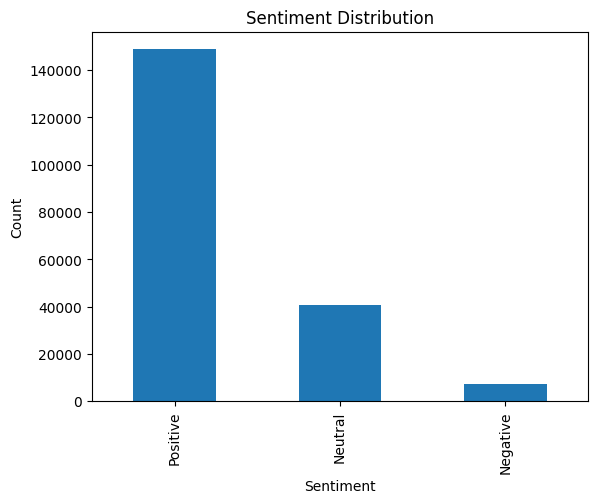

In [48]:


df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [49]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_percent = (sentiment_counts / len(df)) * 100

sentiment_summary = pd.DataFrame({
    "Count": sentiment_counts,
    "Percentage (%)": sentiment_percent.round(2)
})

sentiment_summary


,Count,Percentage (%)
sentiment,,
Positive,148866,75.67
Neutral,40609,20.64
Negative,7252,3.69


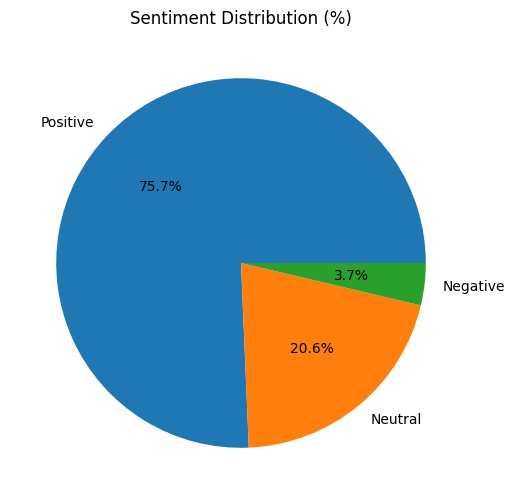

In [50]:
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title("Sentiment Distribution (%)")
plt.ylabel("")
plt.show()


## 6. Ratings vs Sentiment
We compare rating values (0–5) with sentiment classification.


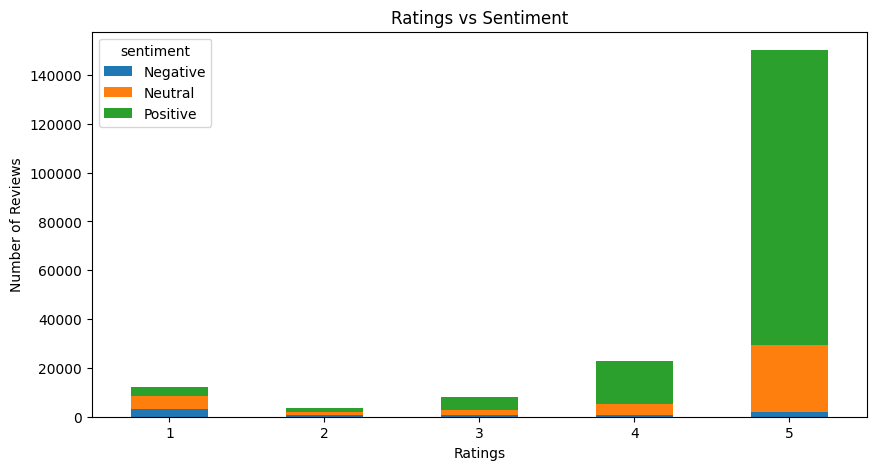

In [20]:


pd.crosstab(df['ratings'], df['sentiment']).plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Ratings vs Sentiment")
plt.xlabel("Ratings")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()


## 6.1 Average Polarity by Rating
This chart shows how sentiment polarity changes with rating values. Higher ratings should generally have higher polarity scores.


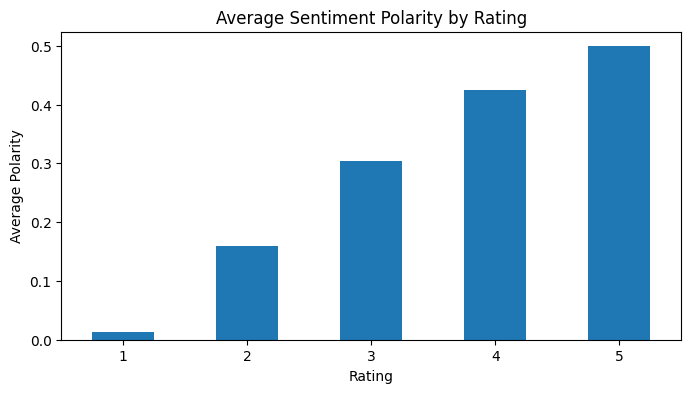

In [53]:
avg_polarity_by_rating = df.groupby("ratings")["polarity"].mean()

plt.figure(figsize=(8,4))
avg_polarity_by_rating.plot(kind="bar")
plt.title("Average Sentiment Polarity by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Polarity")
plt.xticks(rotation=0)
plt.show()


## 7. Issue Identification (Negative Reviews)
We analyze the most common keywords in negative reviews to understand user complaints.


In [21]:
negative_df = df[df['sentiment'] == "Negative"]
negative_df.shape


(7252, 7)

In [29]:


stopwords = set([
    "i","me","my","myself","we","our","you","your","yours",
    "he","she","it","they","them","this","that","these","those",
    "a","an","the","and","or","but","if","is","am","are","was","were",
    "be","been","being","to","of","in","on","for","with","as","at","by",
    "from","up","down","out","about","into","over","after","before",
    "do","does","did","doing","have","has","had","having",
    "not","no","nor","so","too","very","can","could","would","should",
    "just","also","its","im","dont","didnt","cant","wont"
])

def clean_text_words(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [w for w in words if w not in stopwords and len(w) > 2]
    return words

negative_words = []
for review in negative_df['review']:
    negative_words.extend(clean_text_words(review))

common_negative_clean = Counter(negative_words).most_common(20)
common_negative_clean


[('app', 2054),
 ('bad', 807),
 ('wrong', 786),
 ('chatgpt', 597),
 ('when', 597),
 ('use', 517),
 ('like', 511),
 ('even', 495),
 ('time', 482),
 ('answer', 466),
 ('chat', 438),
 ('all', 427),
 ('doesnt', 377),
 ('information', 359),
 ('gpt', 345),
 ('answers', 342),
 ('worst', 342),
 ('give', 335),
 ('please', 332),
 ('because', 314)]

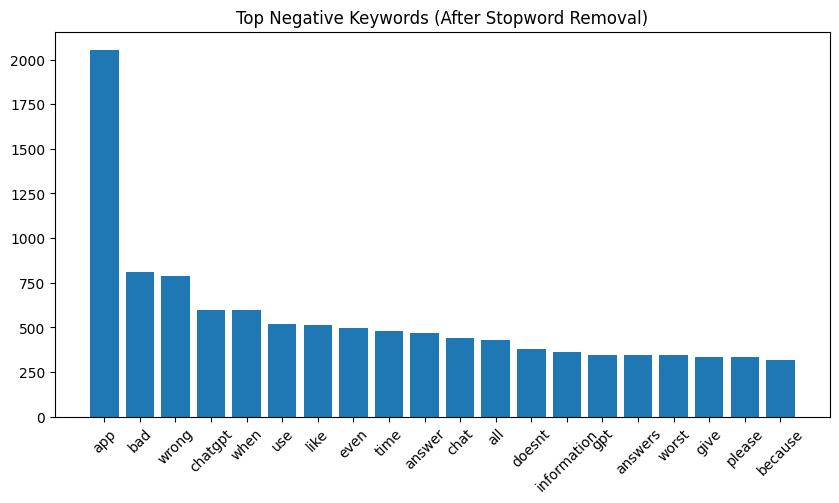

In [30]:
words, counts = zip(*common_negative_clean)

plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top Negative Keywords (After Stopword Removal)")
plt.show()


## 7.1 Top 10 Most Negative Reviews
Below are the reviews with the lowest polarity scores. These represent the strongest negative opinions and help identify key user frustrations.


In [51]:

top_negative = df.sort_values("polarity").head(10)[['review', 'ratings', 'polarity', 'subjectivity', 'review_date']]
top_negative


,review,ratings,polarity,subjectivity,review_date
114304,Very boring 😞 has ditels,1,-1.0,1.0,2024-03-28 06:24:39
40224,disgusting,1,-1.0,1.0,2024-07-06 16:23:07
145113,The Worst app ever!,1,-1.0,1.0,2023-08-05 01:30:01
145490,It's insane,5,-1.0,1.0,2023-11-22 18:47:14
46740,horrible you need to pay money for literally e...,1,-1.0,1.0,2024-06-29 08:32:09
114691,"insane, I can do lot and learn a lot with it",5,-1.0,1.0,2023-12-12 22:53:37
174122,Worst working,1,-1.0,1.0,2024-01-27 13:26:33
83302,Is terrible just terrible,1,-1.0,1.0,2024-05-12 08:41:47
131996,Yeah terrible why can't I create an account wh...,1,-1.0,1.0,2024-01-28 18:51:18
123463,when i go to login to this app no ​​otp is com...,1,-1.0,1.0,2023-09-16 10:01:50


## 8. Positive Feedback Analysis
We extract keywords from positive reviews and visualize them using WordCloud.


In [33]:
positive_df = df[df['sentiment'] == "Positive"]

positive_words = []
for review in positive_df['review']:
    positive_words.extend(clean_text_words(review))

from collections import Counter
common_positive = Counter(positive_words).most_common(20)
common_positive


[('app', 43683),
 ('good', 38903),
 ('best', 18304),
 ('nice', 13686),
 ('great', 11833),
 ('helpful', 9598),
 ('amazing', 8584),
 ('love', 8511),
 ('chatgpt', 8064),
 ('useful', 7454),
 ('really', 6969),
 ('like', 6609),
 ('excellent', 6119),
 ('use', 6027),
 ('awesome', 5029),
 ('all', 4914),
 ('more', 4782),
 ('chat', 4619),
 ('much', 3901),
 ('gpt', 3896)]

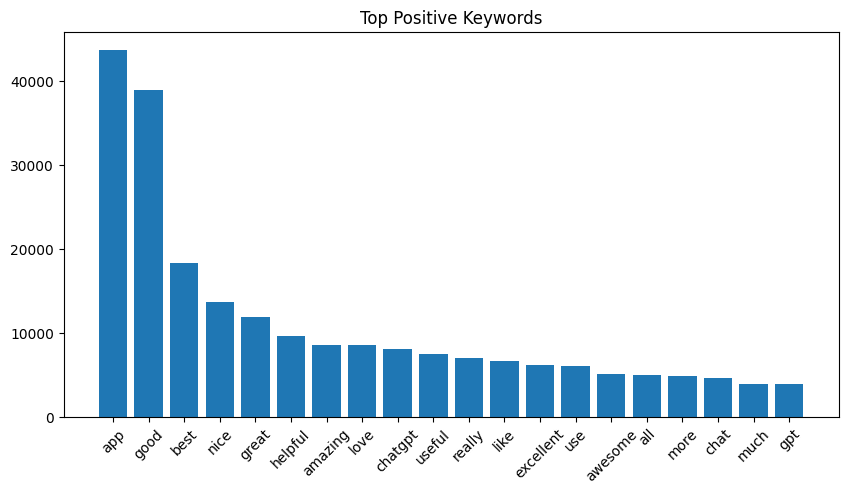

In [34]:
words, counts = zip(*common_positive)

plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top Positive Keywords")
plt.show()

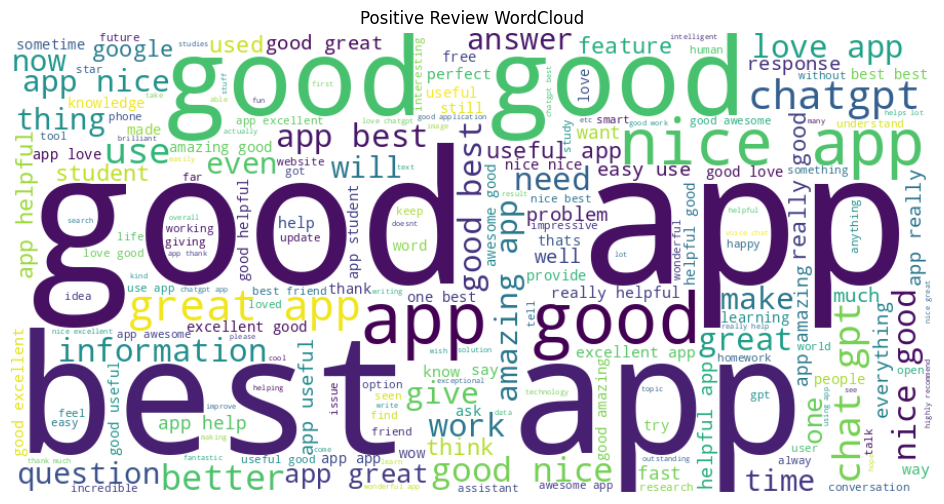

In [45]:


positive_text = " ".join(positive_words)

wc = WordCloud(width=900, height=450, background_color="white").generate(positive_text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Review WordCloud")
plt.show()


## 8.1 Top 10 Most Positive Reviews
Below are the reviews with the highest polarity scores. These represent the strongest positive opinions and highlight what users appreciate most.


In [52]:
top_positive = df.sort_values("polarity", ascending=False).head(10)[['review', 'ratings', 'polarity', 'subjectivity', 'review_date']]
top_positive

,review,ratings,polarity,subjectivity,review_date
86356,the app is awesome it helps with almost everyt...,5,1.0,1.0,2024-05-07 16:33:24
195635,Awesome....,5,1.0,1.0,2023-07-25 15:13:56
195640,The best!!!!!!!,5,1.0,0.3,2023-10-02 09:04:46
195643,Superb....,5,1.0,1.0,2023-07-26 17:55:03
195644,Superb....,5,1.0,1.0,2024-01-09 07:03:43
36,This is the best app ever for writing and assi...,5,1.0,0.3,2024-08-23 18:27:56
41,best,4,1.0,0.3,2024-08-23 18:14:01
46,awesome app,5,1.0,1.0,2024-08-23 18:11:37
86446,This is wonderful platform to get brainstormin...,4,1.0,1.0,2024-04-15 19:15:01
86452,Excellent app!!! Specifically listening to the...,5,1.0,1.0,2024-04-17 11:11:34


## 9. Time-Series Sentiment Trend
We track how sentiment changes over time by grouping reviews month-wise.


In [26]:
df['month'] = df['review_date'].dt.to_period('M').astype(str)


10.2 Trend plot

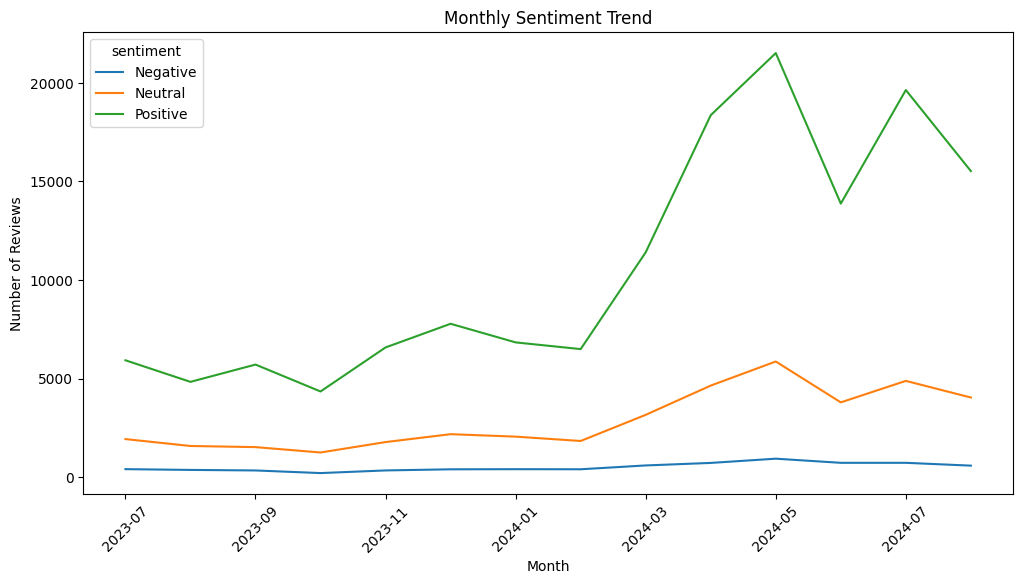

In [27]:
monthly_sentiment = df.groupby(['month','sentiment']).size().unstack().fillna(0)

monthly_sentiment.plot(figsize=(12,6))
plt.title("Monthly Sentiment Trend")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()


## 10. Summary & Conclusion
We summarize sentiment statistics and provide key insights and recommendations.


In [28]:
summary = df.groupby("sentiment").agg(
    total_reviews=("review", "count"),
    avg_rating=("ratings", "mean"),
    avg_polarity=("polarity", "mean"),
    avg_subjectivity=("subjectivity", "mean")
)

summary


,total_reviews,avg_rating,avg_polarity,avg_subjectivity
sentiment,,,,
Negative,7252,2.597628,-0.358699,0.604974
Neutral,40609,4.184811,0.000284,0.057544
Positive,148866,4.683326,0.607731,0.637308


# Executive Summary
- **Total Reviews Analyzed:** 196,721  
- **Sentiment Split:**
  - Positive: **148,866 (~75.7%)**
  - Neutral: **40,609 (~20.6%)**
  - Negative: **7,252 (~3.7%)**
- Users mainly appreciate ChatGPT for being **helpful, useful, and great**.
- Negative feedback is driven by **wrong answers, unreliable information, and app issues**.
- Sentiment trend over time shows how user satisfaction evolves **month-wise**.

---

# Final Insights & Recommendations

## Key Findings
- Most reviews are **Positive**, showing strong overall satisfaction.
- Positive keywords include: **good, best, great, helpful, useful, amazing, love**.
- Negative reviews highlight issues like: **wrong answers, poor information quality, app issues**.
- Ratings and sentiment show strong alignment (**high ratings → positive sentiment**).

## Recommendations
1. Improve answer accuracy to reduce incorrect responses.
2. Improve app reliability and reduce failures (e.g., “doesn't work”).
3. Add clearer explanations when responses are limited.
4. Improve consistency in response quality.

## Conclusion
ChatGPT receives overwhelmingly positive feedback, especially for productivity and learning support, but improvements in reliability and accuracy can further enhance user experience.
